# FaceNet: Face verification and face recognition

We will build a face recognition system. Ideas have been taken from the following paper [FaceNet](https://arxiv.org/pdf/1503.03832.pdf). 

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
import inception_resnet_v1
model = inception_resnet_v1.InceptionResNetV1()
model.load_weights('/Users/kaisarimtiyaz/Desktop/facenet-face-verification-and-face-recognition/keras-facenet-h5/model.h5')

In [8]:
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_3')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


In [9]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # I  Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    
    # I  Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    
    # I  Step 3: Subtract the two previous distances and add alpha
    basic_loss = tf.subtract(pos_dist, neg_dist) + alpha
    
    # I  Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    
    return loss

In [ ]:
tf.random.set_seed(1)
y_true = (None, None, None) # It is not used
y_pred = (tf.keras.backend.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
          tf.keras.backend.random_normal([3, 128], mean=1, stddev=1, seed = 1),
          tf.keras.backend.random_normal([3, 128], mean=3, stddev=4, seed = 1))
loss = triplet_loss(y_true, y_pred)

assert isinstance(loss, tf.Tensor), "Use tensorflow functions"
print("loss = " + str(loss))

y_pred_perfect = ([1., 1.], [1., 1.], [1., 1.,])
loss = triplet_loss(y_true, y_pred_perfect, 5)
assert loss == 5, "Wrong value. Did you add the alpha to basic_loss?"
y_pred_perfect = ([1., 1.],[1., 1.], [0., 0.,])
loss = triplet_loss(y_true, y_pred_perfect, 3)
assert loss == 1., "Wrong value. Check that pos_dist = 0 and neg_dist = 2 in this example"
y_pred_perfect = ([1., 1.],[0., 0.], [1., 1.,])
loss = triplet_loss(y_true, y_pred_perfect, 0)
assert loss == 2., "Wrong value. Check that pos_dist = 2 and neg_dist = 0 in this example"
y_pred_perfect = ([0., 0.],[0., 0.], [0., 0.,])
loss = triplet_loss(y_true, y_pred_perfect, -2)
assert loss == 0, "Wrong value. Are you taking the maximum between basic_loss and 0?"
y_pred_perfect = ([[1., 0.], [1., 0.]],[[1., 0.], [1., 0.]], [[0., 1.], [0., 1.]])
loss = triplet_loss(y_true, y_pred_perfect, 3)
assert loss == 2., "Wrong value. Are you applying tf.reduce_sum to get the loss?"
y_pred_perfect = ([[1., 1.], [2., 0.]], [[0., 3.], [1., 1.]], [[1., 0.], [0., 1.,]])
loss = triplet_loss(y_true, y_pred_perfect, 1)
if (loss == 4.):
    raise Exception('Perhaps you are not using axis=-1 in reduce_sum?')
assert loss == 5, "Wrong value. Check your implementation"

loss = tf.Tensor(527.2596, shape=(), dtype=float32)


In [14]:
FRmodel = model

### Face verification

In [15]:
# I tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [103]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["kaisar"] = img_to_encoding("kaisar3.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

Loading my image: 

In [ ]:
kaisar = tf.keras.preprocessing.image.load_img("kaisar.jpg", target_size=(160, 160))

In [ ]:
np.around(np.array(kaisar) / 255.0, decimals=12).shape

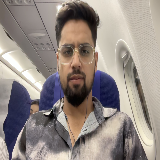

In [106]:
kaisar

In [109]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
        image_path -- path to an image
        identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
        database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
        model -- your Inception model instance in Keras
    
    Returns:
        dist -- distance between the image_path and the image of "identity" in the database.
        door_open -- True, if the door should open. False otherwise.
    """

    # I  Step 1: Compute the encoding for the image. Use img_to_encoding() see example above
    encoding = img_to_encoding(image_path, model)
    
    # I  Step 2: Compute distance with identity's image
    dist = np.linalg.norm(encoding - database[identity])
    
    # I  Step 3: Open the door if dist < 0.7, else don't open
    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False

    return dist, door_open

In [ ]:
assert(np.allclose(verify("images/camera_1.jpg", "bertrand", database, FRmodel), (0.54364836, True)))
assert(np.allclose(verify("images/camera_3.jpg", "bertrand", database, FRmodel), (0.38616243, True)))
assert(np.allclose(verify("images/camera_1.jpg", "younes", database, FRmodel), (1.3963861, False)))
assert(np.allclose(verify("images/camera_3.jpg", "younes", database, FRmodel), (1.3872949, False)))

verify("images/camera_0.jpg", "younes", database, FRmodel)

It's bertrand, welcome in!
It's bertrand, welcome in!
It's not younes, please go away
It's not younes, please go away
It's younes, welcome in!


(0.5992946, True)

In [111]:
verify("kaisar2.jpg", "kaisar", database, FRmodel)

It's kaisar, welcome in!


(0.69003487, True)

### 5.2 - Face recognition

In [114]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
        image_path -- path to an image
        database -- database containing image encodings along with the name of the person on the image
        model -- your Inception model instance in Keras
    
    Returns:
        min_dist -- the minimum distance between image_path encoding and the encodings from the database
        identity -- string, the name prediction for the person on image_path
    """
    
    # I # Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above
    encoding =  img_to_encoding(image_path, model)
    
    # I # Step 2: Find the closest encoding
    
    # I  Initialize "min_dist" to a large value, say 100
    min_dist = 100
    
    # I  Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # I  Compute L2 distance between the target "encoding" and the current db_enc from the database
        dist = np.linalg.norm(encoding - db_enc)

        # I  If this distance is less than the min_dist, then set min_dist to dist, and identity to name
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
    return min_dist, identity

In [117]:
# I  BEGIN UNIT TEST
# I  Test 1 with Younes pictures 
who_is_it("images/camera_0.jpg", database, FRmodel)

# I  Test 2 with Younes pictures 
test1 = who_is_it("images/camera_0.jpg", database, FRmodel)
assert np.isclose(test1[0], 0.5992946)
assert test1[1] == 'younes'

# I  Test 3 with Younes pictures 
test2 = who_is_it("images/younes.jpg", database, FRmodel)
assert np.isclose(test2[0], 0.0)
assert test2[1] == 'younes'
# I  END UNIT TEST

it's younes, the distance is 0.5992946
it's younes, the distance is 0.5992946
it's younes, the distance is 0.0
